In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
from itertools import chain

plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kaon_ntuple_Aug4.root")




In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x
    
def pz_smear(pz):
    pz_array = []
    for part in pz:
        for element in part:
            if element <= 50:
                pz_perc = random.gauss(1,0.0404);
            elif element <= 100: 
                pz_perc = random.gauss(1,0.0410);
            elif element <= 250: 
                pz_perc = random.gauss(1,0.0415);
            elif element <= 500: 
                pz_perc = random.gauss(1,0.0420);
            elif element <= 1000: 
                pz_perc = random.gauss(1,0.0435);
            elif element <= 2000:  
                pz_perc = random.gauss(1,0.0477);
            elif element <= 3000:  
                pz_perc = random.gauss(1,0.0523);
            elif element <= 4000:  
                pz_perc = random.gauss(1,0.0573);            
            else:    
                pz_perc = random.gauss(1,0.06);
            pz_array=np.append(pz_array, [pz_perc])
    return (pz_array)

def px_smear(p):
    px_array = []
    for part in p:
        for element in part:
            if element <= 100:
                px_uncer = random.gauss(0,3.00);
            elif element <= 400: 
                px_uncer = random.gauss(0,3.20);
            elif element <= 500: 
                px_uncer = random.gauss(0,3.20);
            elif element <= 1000: 
                px_uncer = random.gauss(0,3.40);
            elif element <= 1300: 
                px_uncer = random.gauss(0,3.50);
            elif element <= 2000:  
                px_uncer = random.gauss(0,3.85);           
            else:    
                px_uncer = random.gauss(0,3.85);
            px_array=np.append(px_array, [px_uncer])
    return (px_array)

def py_smear(p):
    py_array = []
    for part in p:
        for element in part:
            if element <= 100:
                py_uncer = random.gauss(0,3.75);
            elif element <= 350: 
                py_uncer = random.gauss(0,3.80);
            elif element <= 500: 
                py_uncer = random.gauss(0,4.20);
            elif element <= 1000: 
                py_uncer = random.gauss(0,4.80);
            elif element <= 1200: 
                py_uncer = random.gauss(0,4.98);
            elif element <= 2000:  
                py_uncer = random.gauss(0,3.85);           
            else:    
                py_uncer = random.gauss(0,5.50);
            py_array=np.append(py_array, [py_uncer])
    return (py_array)

In [4]:
hists = {}
hists["kaon_e"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"$K^+$ Kinetic Energy [MeV]", 40, 0, 2000), 
                            ) 
hists["kaon_hist"] = hist.Hist("Sim Kaons",
                                hist.Bin("m", r"$K^+$ Mass [MeV]", 40, 450, 550), 
                            )  
hists["daus_hist"] = hist.Hist("Sim Kaons",
                                hist.Bin("m", r"$K^+$ Mass [MeV]", 40, 450, 550), 
                            )   
hists["daus_smear_hist"] = hist.Hist("Sim Kaons",
                                hist.Bin("m", r"$K^+$ Mass [MeV]", 40, 450, 550), 
                            )     

In [5]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_Particle']
    sim_particle_n = ldmx_events['n']['Sim_Particle']
    sim_particle_dau1 = ldmx_events['Sim_Particle_dau1']
    sim_particle_dau2 = ldmx_events['Sim_Particle_dau2']
    sim_particle_dau3 = ldmx_events['Sim_Particle_dau3']
    
    klong_mask = sim_particle.pdgID == 130
    kshort_mask = sim_particle.pdgID == 310
    
    piplus_mass = 139.57
    pi0_mass    = 134.977

    decay_mask  = ((sim_particle_dau2.momdecay)==1)
    print(sim_particle.decay)
    #decay 1: pi+, pi0
    #decay 2: muon+, numu
    #decay 8: e-, n0, n0
    print(sim_particle_dau1.pdgID)
    print(sim_particle_dau2.pdgID)
    print(sim_particle_dau3.pdgID)
    #learn what decay needs to be
    
    dau1 = get_vector(sim_particle_dau1[decay_mask])
    dau2 = get_vector(sim_particle_dau2[decay_mask])
#     dau3 = get_vector(sim_particle_dau3[decay_mask])
#     dausum = (dau1 + dau2 + dau3)
    dausum = (dau1 + dau2)
    
    new_px1 = px_smear(dau1.p)+flat(dau1.px)
    new_px2 = px_smear(dau2.p)+flat(dau2.px)
#     new_px3 = px_smear(dau3.p)+flat(dau3.px)
    new_py1 = py_smear(dau1.p)+flat(dau1.py)
    new_py2 = py_smear(dau2.p)+flat(dau2.py)
#     new_py3 = py_smear(dau3.p)+flat(dau3.py)
    new_pz1 = pz_smear(dau1.pz)*flat(dau1.pz)
    new_pz2 = pz_smear(dau2.pz)*flat(dau2.pz)
#     new_pz3 = pz_smear(dau3.pz)*flat(dau3.pz)
    
    new_psq1 = new_px1**2+new_py1**2+new_pz1**2
    new_psq2 = new_px2**2+new_py2**2+new_pz2**2
#     new_psq3 = new_px3**2+new_py3**2+new_pz3**2
    new_e1 = (np.sqrt(new_psq1+piplus_mass**2))
    new_e2 = (np.sqrt(new_psq2+pi0_mass**2))
#     new_e3 = (np.sqrt(new_psq3+piplus_mass**2))
    
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    dau1_smear =  ak.zip({"x": new_px1,
                    "y": new_py1,
                    "z": new_pz1,
                    "t": new_e1,
                    },
                    with_name="LorentzVector")
    dau2_smear =  ak.zip({"x": new_px2,
                    "y": new_py2,
                    "z": new_pz2,
                    "t": new_e2,
                    },
                    with_name="LorentzVector")
#     dau3_smear =  ak.zip({"x": new_px3,
#                     "y": new_py3,
#                     "z": new_pz3,
#                     "t": new_e3,
#                     },
#                     with_name="LorentzVector")
#     dausum_smear =(dau1_smear + dau2_smear + dau3_smear)
    dausum_smear =(dau1_smear + dau2_smear)
    
    hists["kaon_e"].fill(      
                                 e=flat(sim_particle.e),
                                )
    hists["kaon_hist"].fill(      
                                 m=flat(sim_particle[decay_mask].mass),
                                )
    hists["daus_hist"].fill(      
                                 m=flat(dausum.mass),
                                )
    hists["daus_smear_hist"].fill(      
                                 m=flat(dausum_smear.mass),
                                )
    
    return

In [6]:
nchunk = 0
for chunk in ldmx_dict:
    #if nchunk >= 1: break
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
[[1], [2], [2], [8], [1], [1], [2], [2], [8], [8]]
[[211], [-13], [-13], [11], [211], [211], [-13], [-13], [321], [321]]
[[111], [14], [14], [2.11e+03], [111], [111], [14], [14], [11], [11]]
[[], [], [], [2.11e+03], [], [], [], [], [], []]


<Hist (m) instance at 0x13128e4f0>


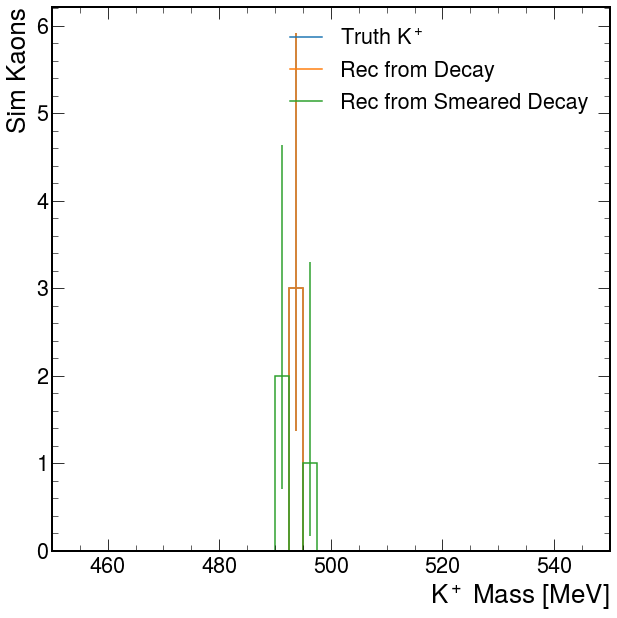

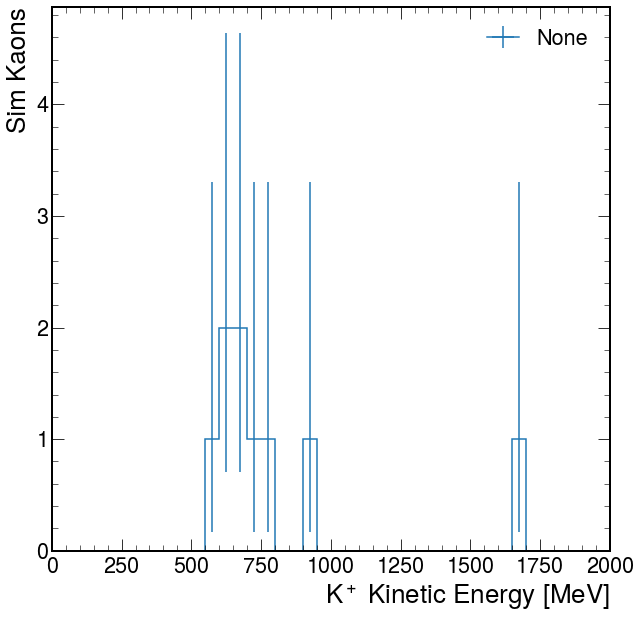

In [8]:
print(hists["kaon_hist"])
fig, ax = plt.subplots()
hist.plot1d(hists["kaon_hist"],ax=ax,clear=False);
hist.plot1d(hists["daus_hist"],ax=ax,clear=False);
hist.plot1d(hists["daus_smear_hist"],ax=ax,clear=False);
leg = ax.legend([r'Truth $K^+$', r'Rec from Decay', r'Rec from Smeared Decay'])

fig, ax = plt.subplots()
hist.plot1d(hists["kaon_e"],ax=ax,clear=False);